# Day 5

## Part 1

- There are a series of complicated mappings defined by the puzzle input
- Find the lowest location number of all the input seed numbers

In [36]:
from copy import deepcopy
from matplotlib import pyplot as plt
from tqdm import tqdm

from advent_of_code_utils.advent_of_code_utils import (
    ParseConfig, parse_from_file, markdown
)

In [37]:
parser = ParseConfig('\n\n', ParseConfig(' map:\n',
    [str, ParseConfig('\n', ParseConfig(' ', int))]
))

parsed_data = parse_from_file('puzzle_input\\day_5.txt', parser)

# seeds have their own format
temp =  parsed_data[0][0].split(': ')[-1]
seeds = [int(value) for value in temp.split(' ')]
# disregard the seeds item leaving the other mappings
mappings = parsed_data[1:]

print(f'seeds: {str(seeds)[:60]}...')
print(f'{str(mappings[0])[:60]}...')

seeds: [3429320627, 235304036, 1147330745, 114559245, 1684000747, 4...
['seed-to-soil', [[583826644, 2288418886, 120919689], [26667...


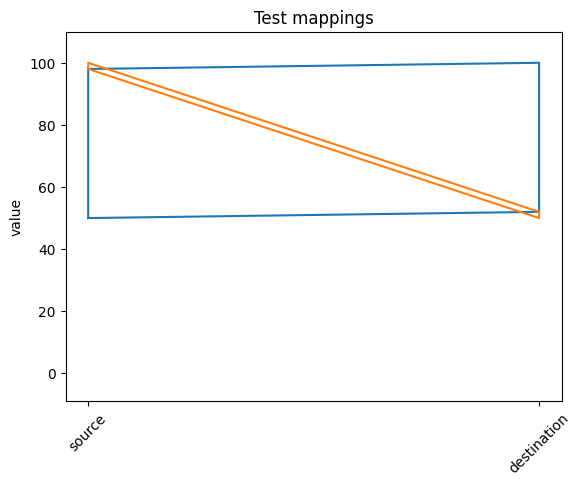

In [38]:
class Mapper:
    """does on-the-fly mappings to save having to store big lists"""
    def __init__(self, mappings: list[list[int, int, int]]):
        self._mappings = sorted(mappings, key=lambda x: x[1])
    
    def convert(self, value: int) -> int:
        """uses the mapping values to figure out how to convert the value"""
        for dest, sour, widt in self._mappings:
            if sour <= value < sour + widt:
                return dest + (value - sour)
        else:
            return value
    
    def plot(self, ax: plt.Axes, x: tuple = (0, 1)) -> None:
        """pops mappings onto an axis"""
        x0, x1 = x
        x_series = [x0, x1, x1, x0, x0]
        for dest, sour, widt in self._mappings:
            series =[sour, dest, dest + widt, sour + widt, sour]
            ax.plot(x_series, series)
    

# this is from the example
mapper = Mapper([[50, 98, 2], [52, 50, 48]])

def mapping_plot(
    mappings: [str, Mapper], title: str,
    y_limits: tuple[int] = None
) -> None:
    """sets up a plot with a series of mappers"""
    fig, ax = plt.subplots()
    x_vals = list(range(len(mappings) + 1))
    for (name, mapper), x0, x1 in zip(mappings, x_vals[:-1], x_vals[1:]):
        mapper.plot(ax, (x0, x1))
    ax.set_xticks(x_vals)
    ax.set_xticklabels(
        [name.split('-to-')[0] for name, _ in mappings] +
        [mappings[-1][0].split('-to-')[-1]],
        rotation=45
    )
    ax.set_ylabel('value')
    ax.set_title(title)
    if y_limits is not None:
        offset = y_limits[1] * 0.1
        ax.set_ylim(y_limits[0] - offset, y_limits[1] + offset)

mapping_plot(
    [['source-to-destination', mapper]], 'Test mappings' , y_limits=(1, 100))

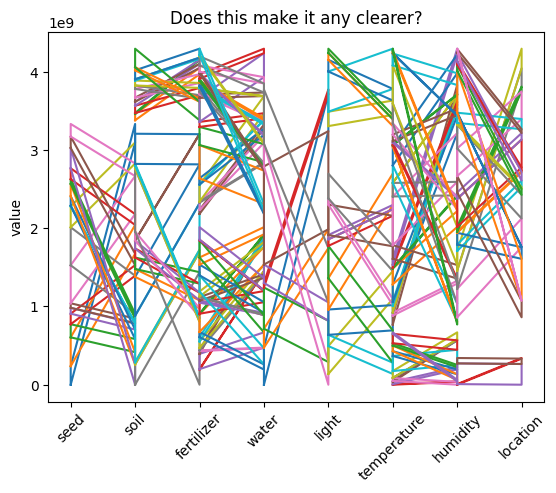

In [39]:
# ok let's convert our input to Mapper instances and see what we're up against
mappers = [[name, Mapper(mapping)] for name, mapping in mappings]
mapping_plot(mappers, 'Does this make it any clearer?')

In [40]:
paths = []
for seed in tqdm(seeds):
    temp = deepcopy(seed)
    paths.append([temp])
    for name, mapper in mappers:
        temp = mapper.convert(temp)
        paths[-1].append(temp)

100%|██████████| 20/20 [00:00<00:00, 8002.11it/s]


Text(0.5, 1.0, 'Following through...')

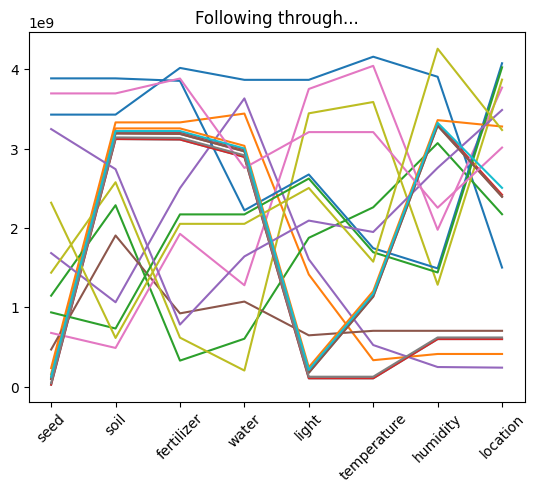

In [41]:
fig, ax = plt.subplots()
x_vals = list(range(len(paths[0])))
for path in paths:
    ax.plot(x_vals, path)
ax.set_xticks(x_vals)
ax.set_xticklabels(
    [name.split('-to-')[0] for name, _ in mappers] +
    [mappers[-1][0].split('-to-')[-1]],
    rotation=45
)
ax.set_title('Following through...')

In [42]:
markdown(
    '### Solution',
    f'The minimum value location is: {min([path[-1] for path in paths])}'
)

### Solution
The minimum value location is: 240320250

## Part 2

- The seed values are actually pairs that define ranges.
- The first value is the start and the second is the length of the range.
- Do the same as part 1 but for all ranges of seeds instead.

In [43]:
class RangeMapper(Mapper):
    """A mapper that can convert ranges of values"""
    def convert_range(
            self, range_start: int, range_length: int) -> list[list[int, int]]:
        """
        takes an input range and finds all the output ranges after mapping
        """
        unmapped_ranges = [[range_start, range_length]]
        mapped_ranges = []
        # for each mapping
        for dest, sour, widt in self._mappings:
            for start, length in unmapped_ranges:
                temp = []
                # if there is no overlap with the input range just
                # re-add that mapping to the temp list
                if any([sour + widt < start, sour > start + length]):
                    temp.append([start, length])
                    continue
                
                # else work out how the range is broken up by this mapping
                if sour <= start and sour + widt > start + length:
                    # range completely surrounded by mapping - map all
                    mapped_ranges.extend([
                        [dest + start - sour, length]
                    ])
                elif sour <= start < sour + widt:
                    # bottom is mapped, top is not
                    mapped_ranges.extend([
                        [dest + (start - sour), sour + widt - start]
                    ])
                    temp.extend([
                        [sour + widt, start + length - (sour + widt)]
                    ])
                elif sour <= start + length < sour + widt:
                    # top is mapped, bottom is not
                    temp.extend([
                        [start, sour - start]
                    ])
                    mapped_ranges.extend([
                        [dest, start + length - sour]
                    ])
                else:
                    # mapping is surrounded so split into 3
                    temp.extend([
                        [start, sour - start],
                        [sour + widt, start + length - (sour + widt)]
                    ])
                    mapped_ranges.extend([
                        [dest, widt]
                    ])

            unmapped_ranges = deepcopy(temp)
        mapped_ranges += unmapped_ranges
        mapped_ranges = [
            [start, length] for start, length in mapped_ranges if length > 0]
        return mapped_ranges

range_mappers = [[name, RangeMapper(mapping)] for name, mapping in mappings]

paths = []
ranges = list(zip(seeds[::2], seeds[1::2]))
for _, mapper in tqdm(range_mappers):
    temp = []
    for range_start, range_length in ranges:
        temp.extend(mapper.convert_range(range_start, range_length))
    ranges = deepcopy(temp)

100%|██████████| 7/7 [00:00<00:00, 61.54it/s]


In [44]:
minimum_location = min([start for start, _ in ranges])

markdown(
    '### Solution',
    f'The minimum location derived from the input seed ranges is: {minimum_location}'
)

### Solution
The minimum location derived from the input seed ranges is: 28580589